# Prediction of BTC-USD Price with algorithm GRU-RNN

## 1. Deklarasi Pustaka

In [1]:
# pustaka untuk manipulasi data-frame
import pandas as pd
from pandas import concat
from pandas import read_csv
from pandas import read_excel
from pandas_datareader import DataReader

# pustaka untuk madnipulasi data-array
import numpy as np
from numpy import concatenate
from numpy import array

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# pustaka untuk visualisasi data
import seaborn as sns
from matplotlib import pyplot
from matplotlib import pyplot as plt

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
        
# pustaka untuk membuat data latih dan data uji.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# pustaka untuk  evaluasi model prediksi
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## 2. Akuisisi Data

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
tf.random.set_seed(42)

In [4]:
# membaca dataset via csv file
dataset = read_csv("dataset/BTC-USD.csv", parse_dates=['Date']);

In [5]:
# set index tanggal
dataset = dataset.set_index("Date");

In [6]:
# menampilkan metadata dataset
dataset.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2896 entries, 2014-12-09 to 2022-11-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2896 non-null   float64
 1   High       2896 non-null   float64
 2   Low        2896 non-null   float64
 3   Close      2896 non-null   float64
 4   Adj Close  2896 non-null   float64
 5   Volume     2896 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 158.4 KB


In [7]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-09,361.894989,363.066986,344.950989,352.218994,352.218994,32915500
2014-12-10,352.204987,352.384003,346.364990,346.364990,346.364990,16427700
2014-12-11,344.339996,361.356995,338.763000,350.506012,350.506012,32431300
2014-12-12,350.833008,352.983002,349.290985,352.541992,352.541992,16989800
2014-12-13,352.381012,352.381012,346.588013,347.376007,347.376007,11675900
...,...,...,...,...,...,...
2022-11-08,20600.671875,20664.607422,17603.544922,18541.271484,18541.271484,118992465607
2022-11-09,18543.761719,18590.458984,15682.692383,15880.780273,15880.780273,102905151606
2022-11-10,15883.158203,18054.312500,15834.018555,17586.771484,17586.771484,83202283721


## 3. Eksplorasi Datsa Analisis

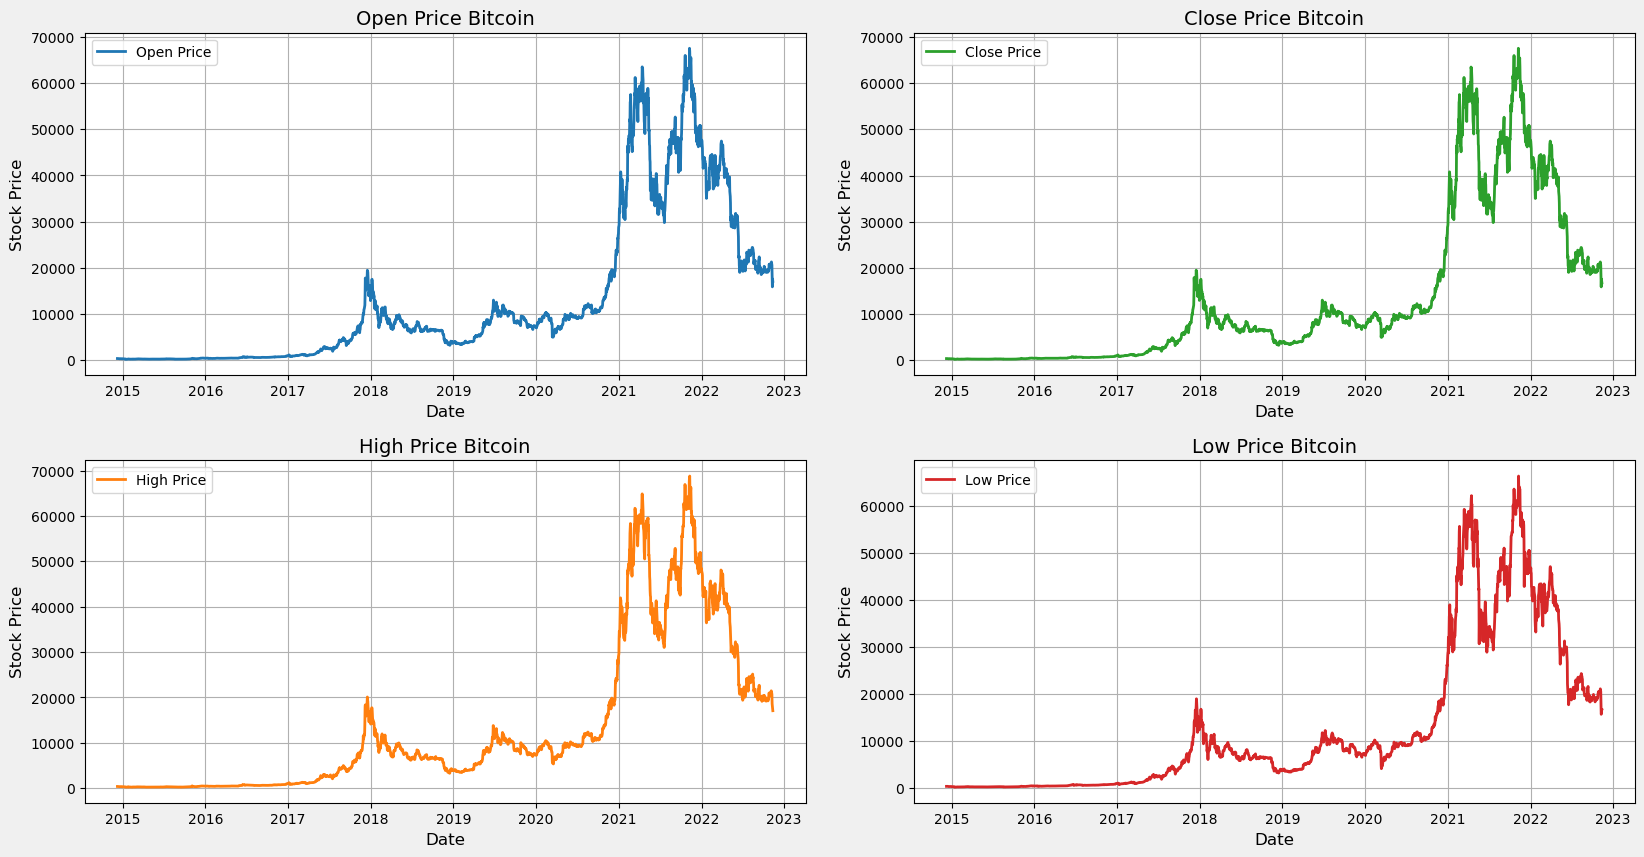

In [8]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(dataset.index.values, dataset["Open"], color="tab:blue", label="Open Price", linewidth=2)

# membuat label-label
ax1.set_title("Open Price Bitcoin", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price", fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(dataset.index.values, dataset["Close"], color="tab:green", label="Close Price", linewidth=2)

# membuat label-label
ax2.set_title("Close Price Bitcoin", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price", fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(dataset.index.values, dataset["High"], color="tab:orange", label="High Price", linewidth=2)

# membuat label-label
ax3.set_title("High Price Bitcoin", fontsize=14)
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price", fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(dataset.index.values, dataset["Low"], color="tab:red", label="Low Price", linewidth=2)

# membuat label-label
ax4.set_title("Low Price Bitcoin", fontsize=14)
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Stock Price", fontsize=12)
ax4.legend(loc='upper left')
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

## 4. Praproses Dataset

- Seleksi Fitur

In [9]:
# memilih fitur close price
dataset = dataset.filter(['Close']);

In [10]:
# convert dataframe to series close price
data = dataset.values

In [11]:
np.round(data[:5],7)

array([[352.218994],
       [346.36499 ],
       [350.506012],
       [352.541992],
       [347.376007]])

In [12]:
data.shape

(2896, 1)

- Normalisasi Data

In [13]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1))

In [14]:
np.round(scaled_data[:5],7)

array([[0.0025838],
       [0.0024969],
       [0.0025583],
       [0.0025885],
       [0.0025119]])

In [15]:
scaled_data.shape

(2896, 1)

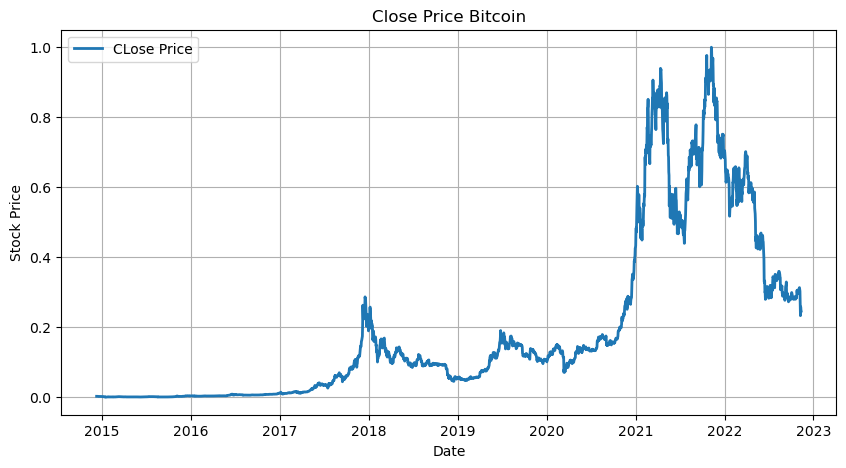

In [16]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset.index.values, scaled_data, color="tab:blue", label="CLose Price", linewidth=2)

# membuat label-label
ax.set_title("Close Price Bitcoin", fontsize=12)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel("Stock Price", fontsize=10)
ax.legend(loc='upper left')
ax.grid(True)

# menampilkan plot
plt.show()

- Data latih dan Data uji

In [17]:
# split data train and test
train_data, test_data = train_test_split(scaled_data, train_size=0.80, test_size=0.20, shuffle=False)

In [18]:
# data train
np.round(train_data[:5],7)

array([[0.0025838],
       [0.0024969],
       [0.0025583],
       [0.0025885],
       [0.0025119]])

In [19]:
train_data.shape

(2316, 1)

In [20]:
# data test
np.round(test_data[:5],7)

array([[0.8861327],
       [0.9397025],
       [0.9338594],
       [0.9368913],
       [0.9110528]])

In [21]:
test_data.shape

(580, 1)

- Supervised Learning

In [22]:
# convert an array of values into a dataset matrix

# function for supervised learning
def create_dataset(look_back, dataset):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):
        
        # insert value X and Y 
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])
        
    # return value X and Y
    return np.array(dataX), np.array(dataY)

In [23]:
# process supervised learning
look_back = 60
x_train, y_train = create_dataset(look_back, train_data)
x_test, y_test = create_dataset(look_back, test_data)

In [24]:
print(x_train.shape, y_train.shape)

(2256, 60) (2256,)


In [25]:
print(x_test.shape, y_test.shape)

(520, 60) (520,)


In [26]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
print(x_train.shape, x_test.shape)

(2256, 60, 1) (520, 60, 1)


## 5. Modeling GRU-RNN

### Percobaan 1 - Vanilla GRU-RNN

In [28]:
tf.random.set_seed(42)

In [29]:
# The GRU-RNN architecture
model_1 = tf.keras.Sequential([
    
    # The input layer
    tf.keras.layers.GRU(units=50, return_sequences=False, input_shape=(x_train.shape[1], 1)),
    
    # The output layer
    tf.keras.layers.Dense(1)
])

In [30]:
# Compile the model GRU
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00075),
    loss='mean_squared_error'
)

In [31]:
# fit network
history_1 = model_1.fit(x_train, y_train, batch_size=8, epochs=50, validation_data=(x_test, y_test), verbose=1, use_multiprocessing=True, shuffle=False)

Epoch 1/50
282/282 [==============================] - 7s 15ms/step - loss: 8.1729e-04 - val_loss: 0.0118
Epoch 2/50
282/282 [==============================] - 3s 12ms/step - loss: 0.0023 - val_loss: 0.0206
Epoch 3/50
282/282 [==============================] - 3s 12ms/step - loss: 0.0016 - val_loss: 0.0104
Epoch 4/50
282/282 [==============================] - 4s 13ms/step - loss: 6.7220e-04 - val_loss: 0.0026
Epoch 5/50
282/282 [==============================] - 3s 12ms/step - loss: 2.1216e-04 - val_loss: 0.0012
Epoch 6/50
282/282 [==============================] - 3s 11ms/step - loss: 1.2601e-04 - val_loss: 9.1856e-04
Epoch 7/50
282/282 [==============================] - 3s 11ms/step - loss: 1.0895e-04 - val_loss: 8.6329e-04
Epoch 8/50
282/282 [==============================] - 3s 12ms/step - loss: 1.0936e-04 - val_loss: 8.7110e-04
Epoch 9/50
282/282 [==============================] - 3s 12ms/step - loss: 1.1433e-04 - val_loss: 8.9462e-04
Epoch 10/50
282/282 [==========================

In [32]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                7950      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [33]:
predictions_1 = model_1.predict(x_test)

17/17 [==============================] - 1s 6ms/step


In [34]:
print(predictions_1[:7])

[[0.5601876 ]
 [0.570865  ]
 [0.54086185]
 [0.594498  ]
 [0.60975283]
 [0.61485595]
 [0.5811893 ]]


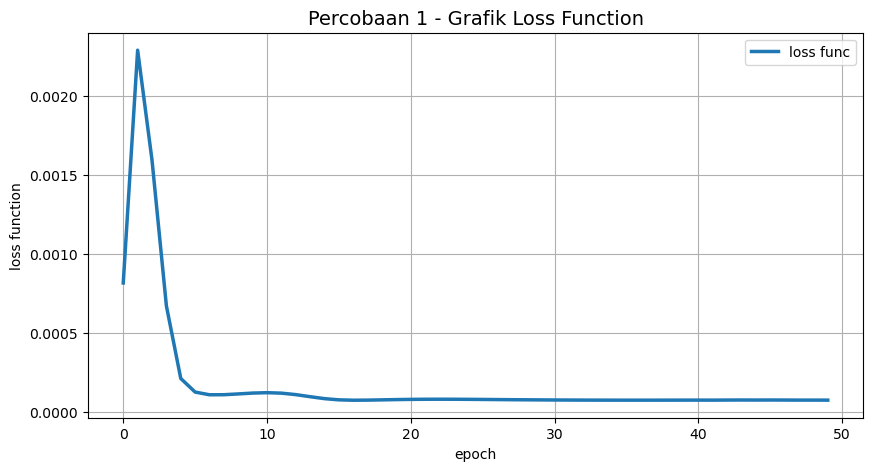

In [35]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history_1.history['loss'], color="tab:blue", label="loss func", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 1 - Grafik Loss Function", fontsize=14)
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

#### Evaluasi Model (Percobaan 1 - Vanilla GRU-RNN)

In [36]:
scores_1 = model_1.evaluate(x_train, y_train)
scores_1

71/71 [==============================] - 1s 6ms/step - loss: 7.4165e-04


0.0007416516891680658

In [37]:
scores_1 = model_1.evaluate(x_test, y_test)
scores_1

17/17 [==============================] - 0s 6ms/step - loss: 6.9688e-04


0.0006968756206333637

- MAE (Mean Absolute Error)

In [38]:
mae_1 = mean_absolute_error(y_test, predictions_1)
print('Test MAE : %.4f' % mae_1)

Test MAE : 0.0218


- MSE (Mean Squared Error)

In [39]:
mse_1 = mean_squared_error(y_test, predictions_1)
print('Test MSE: %.4f' % mse_1)

Test MSE: 0.0007


- RMSE (Root Mean Squared Error)

In [40]:
rmse_1 = sqrt(mse_1)
print('Test RMSE: %.4f' % rmse_1)

Test RMSE: 0.0264


- Corelation pearson

In [41]:
hasil_1 = np.stack((y_test.reshape(-1), predictions_1.reshape(-1)), axis=1)
hasil_1 = pd.DataFrame(hasil_1, columns = ['data_aktual','prediksi'])
hasil_1

,data_aktual,prediksi
0,0.551373,0.560188
1,0.524931,0.570865
2,0.577541,0.540862
3,0.594170,0.594498
4,0.596957,0.609753
...,...,...
515,0.272496,0.327203
516,0.233016,0.296953
517,0.258332,0.257635
518,0.250134,0.279928


In [42]:
r1, p1 = sc.pearsonr(hasil_1["data_aktual"], hasil_1["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r1)+ "dengan signifikansi" +" {:.4f} ".format(p1))

korelasi data akual dengan hasil prediksi 0.9946 dengan signifikansi 0.0000 


#### Visualisasi Data (Percobaan 1 - Vanilla GRU-RNN)

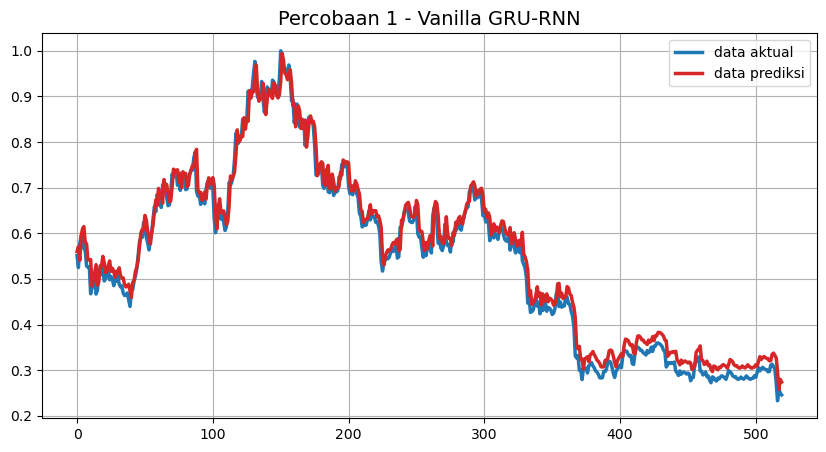

In [43]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(predictions_1, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 1 - Vanilla GRU-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [44]:
# inverse value test predictions
predictions_1 = scaler.inverse_transform(predictions_1)

In [45]:
# shift test predictions for plotting
predictionsPlot_1 = np.empty_like(scaled_data)
predictionsPlot_1[:, :] = np.nan
predictionsPlot_1[(len(dataset) - predictions_1.shape[0]):len(dataset), :] = predictions_1

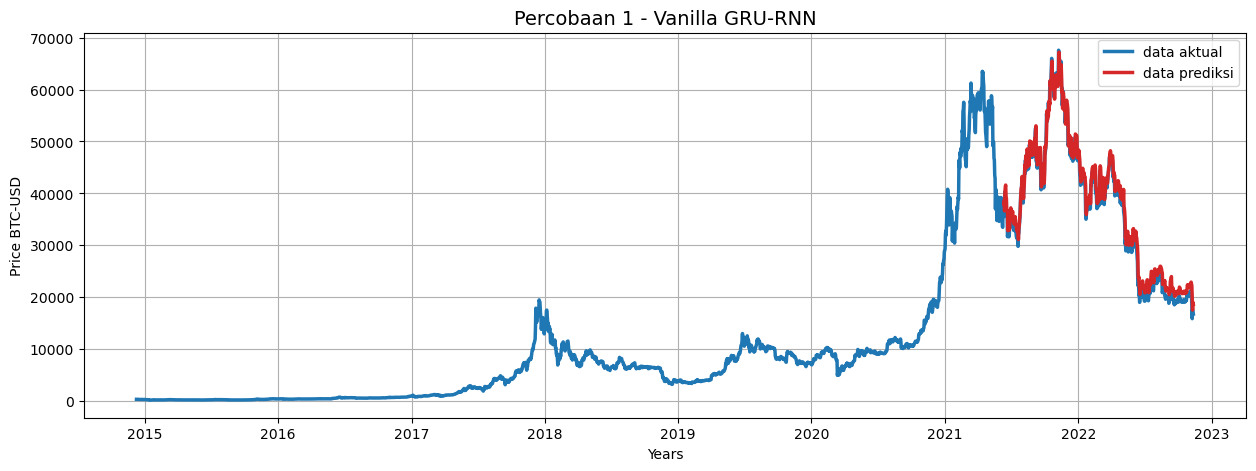

In [46]:
# membuat frame
fig, ax = plt.subplots(figsize = (15,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(dataset.index.values, predictionsPlot_1, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 1 - Vanilla GRU-RNN", fontsize=14)
ax.set_xlabel("Years", fontsize=10)
ax.set_ylabel("Price BTC-USD", fontsize=10)
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

### Percobaan 2 - Stacked GRU-RNN

In [47]:
tf.random.set_seed(42)

In [48]:
# The GRU-RNN architecture
model_2 = tf.keras.Sequential([
    
    # First GRU layer with Dropout regularisation
    tf.keras.layers.GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    
    # Secound GRU layer with Dropout regularisation
    tf.keras.layers.GRU(units=50, return_sequences=False),
    
    # The output layer
    tf.keras.layers.Dense(1)
])

In [49]:
# Compile the model GRU
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [50]:
# fit network
history_2 = model_2.fit(
    x_train, y_train,
    batch_size=8, epochs=50,
    validation_data=(x_test, y_test),
    verbose=1,
    use_multiprocessing=True,
    shuffle=False
)

Epoch 1/50
282/282 [==============================] - 11s 25ms/step - loss: 7.0803e-04 - val_loss: 0.0246
Epoch 2/50
282/282 [==============================] - 6s 21ms/step - loss: 0.0031 - val_loss: 0.0196
Epoch 3/50
282/282 [==============================] - 6s 22ms/step - loss: 0.0040 - val_loss: 0.0176
Epoch 4/50
282/282 [==============================] - 6s 22ms/step - loss: 0.0038 - val_loss: 0.0255
Epoch 5/50
282/282 [==============================] - 6s 21ms/step - loss: 0.0036 - val_loss: 0.0275
Epoch 6/50
282/282 [==============================] - 6s 22ms/step - loss: 0.0032 - val_loss: 0.0250
Epoch 7/50
282/282 [==============================] - 6s 21ms/step - loss: 0.0024 - val_loss: 0.0223
Epoch 8/50
282/282 [==============================] - 5s 19ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 9/50
282/282 [==============================] - 5s 19ms/step - loss: 4.0916e-04 - val_loss: 0.0019
Epoch 10/50
282/282 [==============================] - 5s 18ms/step - loss: 9.4715

In [51]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 60, 50)            7950      
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [52]:
predictions_2 = model_2.predict(x_test)

17/17 [==============================] - 1s 10ms/step


In [53]:
print(predictions_2[:7])

[[0.53564906]
 [0.54545724]
 [0.51845336]
 [0.5726188 ]
 [0.5890176 ]
 [0.5916171 ]
 [0.5603393 ]]


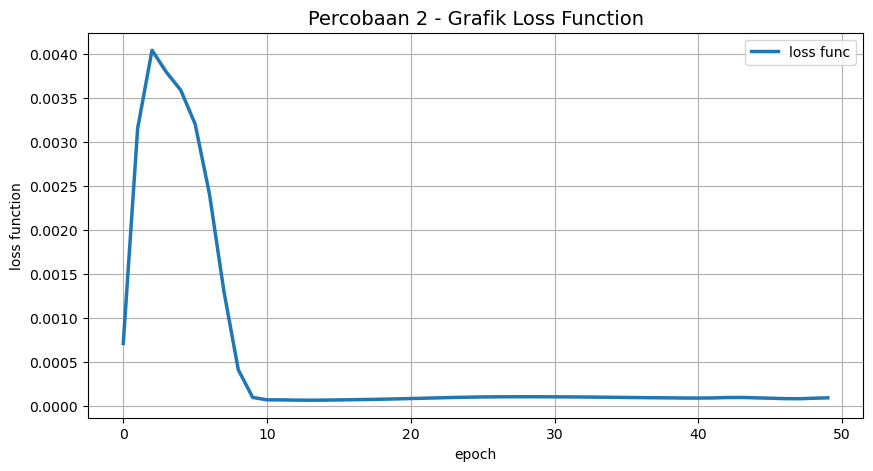

In [54]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history_2.history['loss'], color="tab:blue", label="loss func", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 2 - Grafik Loss Function", fontsize=14)
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

#### Evaluasi Model (Percobaan 2 - Stacked GRU-RNN)

In [55]:
scores_2 = model_2.evaluate(x_train, y_train)
scores_2

71/71 [==============================] - 2s 11ms/step - loss: 2.9662e-04


0.0002966156171169132

In [56]:
scores_2 = model_2.evaluate(x_test, y_test)
scores_2

17/17 [==============================] - 0s 10ms/step - loss: 4.1902e-04


0.0004190234758425504

- MAE (Mean Absolute Error)

In [57]:
mae_2 = mean_absolute_error(y_test, predictions_2)
print('Test MAE : %.4f' % mae_2)

Test MAE : 0.0146


- MSE (Mean Squared Error)

In [58]:
mse_2 = mean_squared_error(y_test, predictions_2)
print('Test MSE: %.4f' % mse_2)

Test MSE: 0.0004


- RMSE (Root Mean Squared Error)

In [59]:
rmse_2 = sqrt(mse_2)
print('Test RMSE: %.4f' % rmse_2)

Test RMSE: 0.0205


- Corelation pearson

In [60]:
hasil_2 = np.stack((y_test.reshape(-1), predictions_2.reshape(-1)), axis=1)
hasil_2 = pd.DataFrame(hasil_2, columns = ['data_aktual','prediksi'])
hasil_2

,data_aktual,prediksi
0,0.551373,0.535649
1,0.524931,0.545457
2,0.577541,0.518453
3,0.594170,0.572619
4,0.596957,0.589018
...,...,...
515,0.272496,0.299045
516,0.233016,0.270229
517,0.258332,0.235362
518,0.250134,0.260308


In [61]:
r2, p2 = sc.pearsonr(hasil_2["data_aktual"], hasil_2["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r2)+ "dengan signifikansi" +" {:.4f} ".format(p2))

korelasi data akual dengan hasil prediksi 0.9946 dengan signifikansi 0.0000 


#### Visualisasi Data (Percobaan 2 - Stacked GRU-RNN)

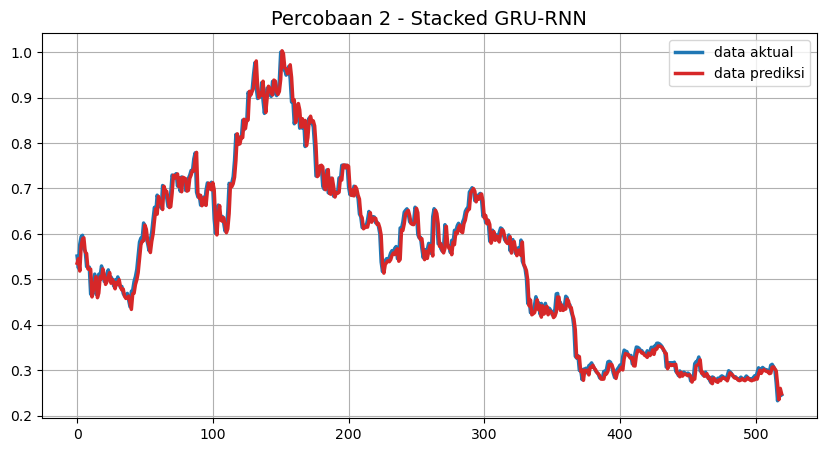

In [62]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(predictions_2, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 2 - Stacked GRU-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [63]:
# inverse value test predictions
predictions_2 = scaler.inverse_transform(predictions_2)

In [64]:
# shift test predictions for plotting
predictionsPlot_2 = np.empty_like(scaled_data)
predictionsPlot_2[:, :] = np.nan
predictionsPlot_2[(len(dataset) - predictions_2.shape[0]):len(dataset), :] = predictions_2

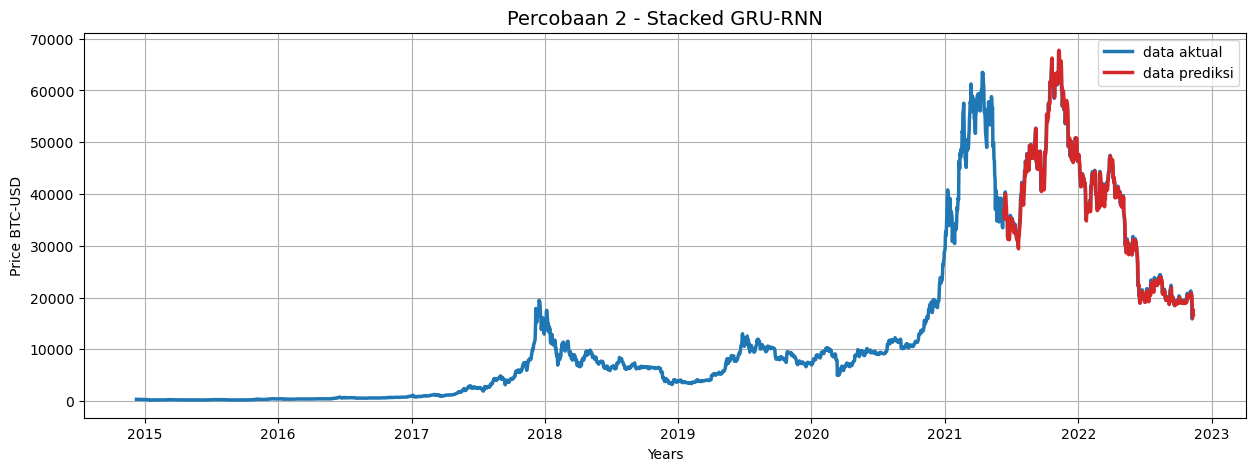

In [65]:
# membuat frame
fig, ax = plt.subplots(figsize = (15,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(dataset.index.values, predictionsPlot_2, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 2 - Stacked GRU-RNN", fontsize=14)
ax.set_xlabel("Years", fontsize=10)
ax.set_ylabel("Price BTC-USD", fontsize=10)
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

### Percobaan 3 - Bidirectional GRU-RNN

In [66]:
tf.random.set_seed(42)

In [67]:
# The GRU-RNN architecture
model_3 = tf.keras.Sequential([
    
    # The input layer
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(units=50, return_sequences=False, input_shape=(x_train.shape[1], 1))
    ),
    
    # The output layer
    tf.keras.layers.Dense(1)
])

In [68]:
# Compile the model GRU
model_3.compile(optimizer='adam', loss='mean_squared_error')

In [69]:
# fit network
history_3 = model_3.fit(
    x_train,
    y_train,
    batch_size=8,
    epochs=50,
    validation_data=(x_test, y_test),
    verbose=1,
    use_multiprocessing=True,
    shuffle=False
)

Epoch 1/50
282/282 [==============================] - 9s 16ms/step - loss: 7.8877e-04 - val_loss: 0.0269
Epoch 2/50
282/282 [==============================] - 3s 12ms/step - loss: 0.0031 - val_loss: 0.0382
Epoch 3/50
282/282 [==============================] - 3s 12ms/step - loss: 0.0025 - val_loss: 0.0334
Epoch 4/50
282/282 [==============================] - 4s 13ms/step - loss: 0.0021 - val_loss: 0.0306
Epoch 5/50
282/282 [==============================] - 4s 12ms/step - loss: 0.0017 - val_loss: 0.0239
Epoch 6/50
282/282 [==============================] - 3s 12ms/step - loss: 0.0011 - val_loss: 0.0148
Epoch 7/50
282/282 [==============================] - 4s 13ms/step - loss: 5.1777e-04 - val_loss: 0.0054
Epoch 8/50
282/282 [==============================] - 4s 12ms/step - loss: 1.8096e-04 - val_loss: 0.0034
Epoch 9/50
282/282 [==============================] - 4s 13ms/step - loss: 1.2531e-04 - val_loss: 0.0029
Epoch 10/50
282/282 [==============================] - 4s 13ms/step - loss:

In [70]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (8, 100)                 15900     
 l)                                                              
                                                                 
 dense_2 (Dense)             (8, 1)                    101       
                                                                 
Total params: 16,001
Trainable params: 16,001
Non-trainable params: 0
_________________________________________________________________


In [71]:
predictions_3 = model_3.predict(x_test)

17/17 [==============================] - 1s 5ms/step


In [72]:
print(predictions_3[:7])

[[0.59077066]
 [0.6025483 ]
 [0.5755745 ]
 [0.6271563 ]
 [0.6389682 ]
 [0.6417078 ]
 [0.6093342 ]]


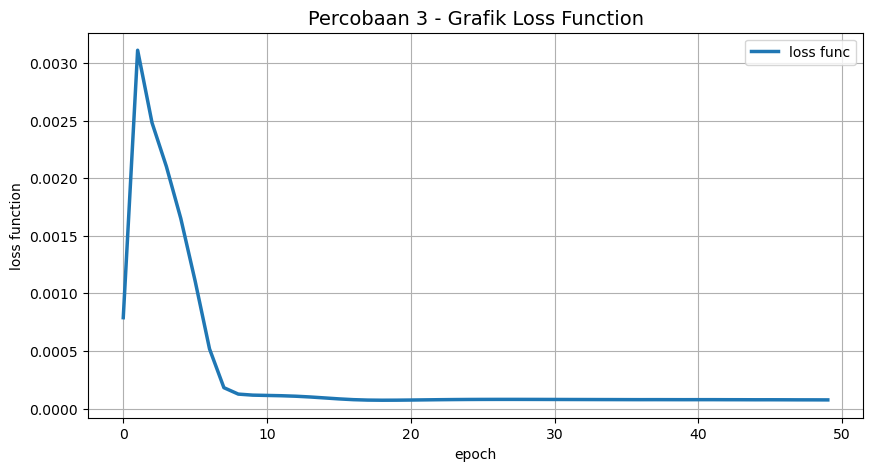

In [73]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history_3.history['loss'], color="tab:blue", label="loss func", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 3 - Grafik Loss Function", fontsize=14)
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

#### Evaluasi Model (Percobaan 3 - Bidirectional GRU-RNN)

In [74]:
scores_3 = model_3.evaluate(x_train, y_train)
scores_3

71/71 [==============================] - 1s 5ms/step - loss: 7.6861e-04


0.0007686053868383169

In [75]:
scores_3 = model_3.evaluate(x_test, y_test)
scores_3

17/17 [==============================] - 0s 5ms/step - loss: 0.0016


0.001592190470546484

- MAE (Mean Absolute Error)

In [76]:
mae_3 = mean_absolute_error(y_test, predictions_3)
print('Test MAE : %.4f' % mae_3)

Test MAE : 0.0353


- MSE (Mean Squared Error)

In [77]:
mse_3 = mean_squared_error(y_test, predictions_3)
print('Test MSE: %.4f' % mse_3)

Test MSE: 0.0016


- RMSE (Root Mean Squared Error)

In [78]:
rmse_3 = sqrt(mse_3)
print('Test RMSE: %.4f' % rmse_3)

Test RMSE: 0.0399


- Corelation pearson

In [79]:
hasil_3 = np.stack((y_test.reshape(-1), predictions_3.reshape(-1)), axis=1)
hasil_3 = pd.DataFrame(hasil_3, columns = ['data_aktual','prediksi'])
hasil_3

,data_aktual,prediksi
0,0.551373,0.590771
1,0.524931,0.602548
2,0.577541,0.575575
3,0.594170,0.627156
4,0.596957,0.638968
...,...,...
515,0.272496,0.337914
516,0.233016,0.308571
517,0.258332,0.270717
518,0.250134,0.294564


In [80]:
r3, p3 = sc.pearsonr(hasil_3["data_aktual"], hasil_3["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r3)+ "dengan signifikansi" +" {:.4f} ".format(p3))

korelasi data akual dengan hasil prediksi 0.9934 dengan signifikansi 0.0000 


#### Visualisasi Data (Percobaan 3 - Bidirectional GRU-RNN)

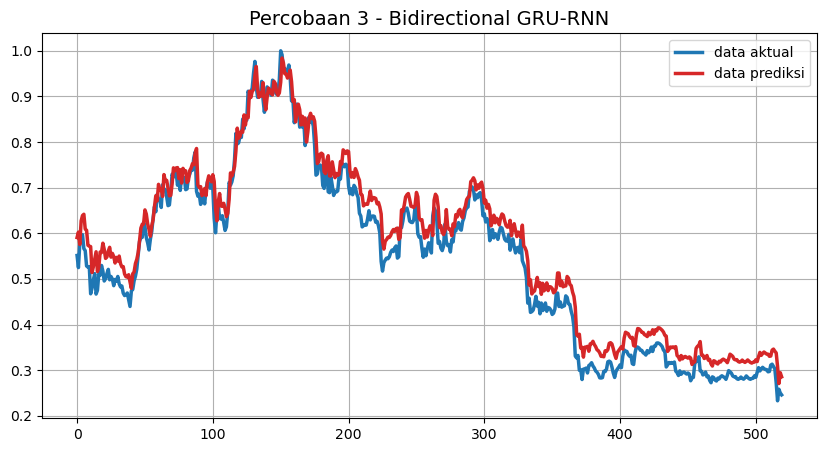

In [81]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(predictions_3, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 3 - Bidirectional GRU-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [82]:
# inverse value test predictions
predictions_3 = scaler.inverse_transform(predictions_3)

In [83]:
# shift test predictions for plotting
predictionsPlot_3 = np.empty_like(scaled_data)
predictionsPlot_3[:, :] = np.nan
predictionsPlot_3[(len(dataset) - predictions_3.shape[0]):len(dataset), :] = predictions_3

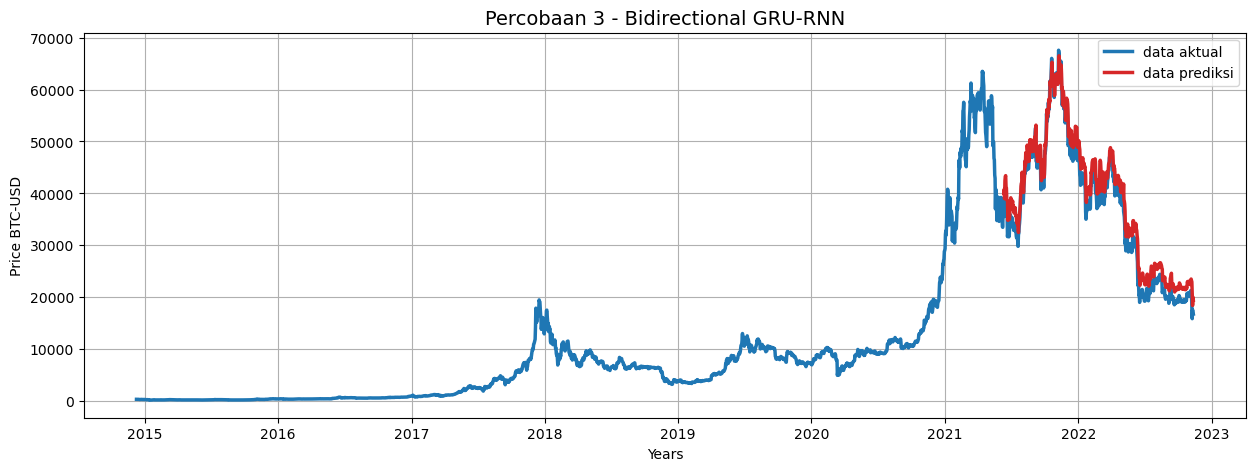

In [84]:
# membuat frame
fig, ax = plt.subplots(figsize = (15,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(dataset.index.values, predictionsPlot_3, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 3 - Bidirectional GRU-RNN", fontsize=14)
ax.set_xlabel("Years", fontsize=10)
ax.set_ylabel("Price BTC-USD", fontsize=10)
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

### Percobaan 4 - Stacked-Bidirectional GRU-RNN

In [85]:
tf.random.set_seed(42)

In [86]:
# The GRU-RNN architecture
model_4 = tf.keras.Sequential([
    
    # First GRU layer with Dropout regularisation
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))
    ),
    
    # Secound GRU layer with Dropout regularisation
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(units=50, return_sequences=False)
    ),
    
    # The output layer
    tf.keras.layers.Dense(1)
])

In [87]:
# Compile the model GRU
model_4.compile(optimizer='adam', loss='mean_squared_error')

In [88]:
# fit network
history_4 = model_4.fit(
    x_train,
    y_train,
    batch_size=8,
    epochs=50,
    validation_data=(x_test, y_test),
    verbose=1,
    use_multiprocessing=True,
    shuffle=False
)

Epoch 1/50
282/282 [==============================] - 13s 24ms/step - loss: 7.5100e-04 - val_loss: 0.0191
Epoch 2/50
282/282 [==============================] - 6s 20ms/step - loss: 0.0025 - val_loss: 0.0211
Epoch 3/50
282/282 [==============================] - 5s 19ms/step - loss: 0.0034 - val_loss: 0.0063
Epoch 4/50
282/282 [==============================] - 6s 20ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 5/50
282/282 [==============================] - 5s 19ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 6/50
282/282 [==============================] - 6s 20ms/step - loss: 6.5959e-04 - val_loss: 0.0015
Epoch 7/50
282/282 [==============================] - 6s 20ms/step - loss: 2.6847e-04 - val_loss: 8.3109e-04
Epoch 8/50
282/282 [==============================] - 6s 20ms/step - loss: 1.1926e-04 - val_loss: 6.2648e-04
Epoch 9/50
282/282 [==============================] - 6s 20ms/step - loss: 8.6558e-05 - val_loss: 6.7965e-04
Epoch 10/50
282/282 [==============================] - 6s 

In [89]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (8, 60, 100)             15900     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (8, 100)                 45600     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (8, 1)                    101       
                                                                 
Total params: 61,601
Trainable params: 61,601
Non-trainable params: 0
_________________________________________________________________


In [90]:
predictions_4 = model_4.predict(x_test)
print(predictions_4[:7])

17/17 [==============================] - 2s 9ms/step
[[0.5661642 ]
 [0.5775653 ]
 [0.5493023 ]
 [0.6015303 ]
 [0.61594015]
 [0.61746836]
 [0.58302957]]


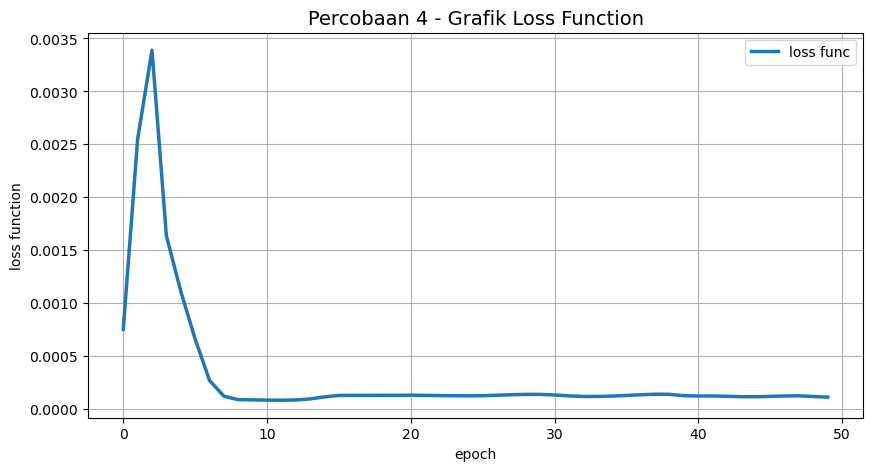

In [91]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history_4.history['loss'], color="tab:blue", label="loss func", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 4 - Grafik Loss Function", fontsize=14)
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

#### Evaluasi Model (Percobaan 4 - Stacked-Bidirectional GRU-RNN)

In [92]:
scores_4 = model_4.evaluate(x_train, y_train)
scores_4

71/71 [==============================] - 2s 10ms/step - loss: 5.2600e-04


0.0005259956233203411

In [93]:
scores_4 = model_4.evaluate(x_test, y_test)
scores_4

17/17 [==============================] - 0s 9ms/step - loss: 5.7939e-04


0.0005793924210593104

- MAE (Mean Absolute Error)

In [94]:
mae_4 = mean_absolute_error(y_test, predictions_4)
print('Test MAE : %.4f' % mae_4)

Test MAE : 0.0179


- MSE (Mean Squared Error)

In [95]:
mse_4 = mean_squared_error(y_test, predictions_4)
print('Test MSE: %.4f' % mse_4)

Test MSE: 0.0006


- RMSE (Root Mean Squared Error)

In [96]:
rmse_4 = sqrt(mse_4)
print('Test RMSE: %.4f' % rmse_4)

Test RMSE: 0.0241


- Corelation pearson

In [97]:
hasil_4 = np.stack((y_test.reshape(-1), predictions_4.reshape(-1)), axis=1)
hasil_4 = pd.DataFrame(hasil_4, columns = ['data_aktual','prediksi'])
hasil_4

,data_aktual,prediksi
0,0.551373,0.566164
1,0.524931,0.577565
2,0.577541,0.549302
3,0.594170,0.601530
4,0.596957,0.615940
...,...,...
515,0.272496,0.292506
516,0.233016,0.265543
517,0.258332,0.231273
518,0.250134,0.254766


In [98]:
r4, p4 = sc.pearsonr(hasil_4["data_aktual"], hasil_4["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r4)+ "dengan signifikansi" +" {:.4f} ".format(p4))

korelasi data akual dengan hasil prediksi 0.9931 dengan signifikansi 0.0000 


#### Visualisasi Data (Percobaan 4 - Stacked-Bidirectional GRU-RNN)

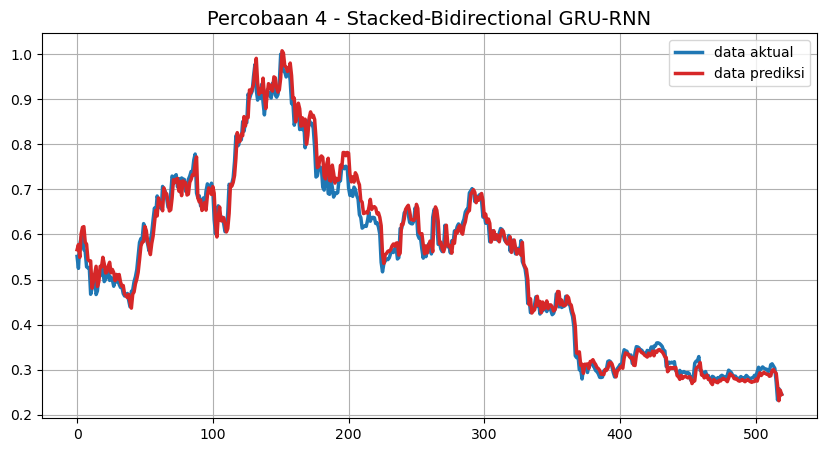

In [99]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(predictions_4, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 4 - Stacked-Bidirectional GRU-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [100]:
# inverse value test predictions
predictions_4 = scaler.inverse_transform(predictions_4)

In [101]:
# shift test predictions for plotting
predictionsPlot_4 = np.empty_like(scaled_data)
predictionsPlot_4[:, :] = np.nan
predictionsPlot_4[(len(dataset) - predictions_4.shape[0]):len(dataset), :] = predictions_4

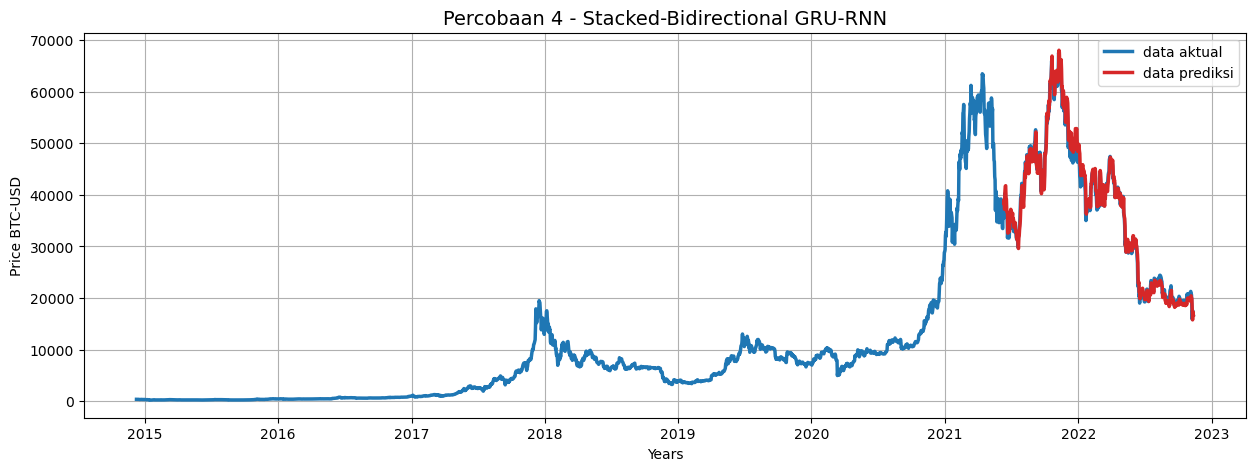

In [102]:
# membuat frame
fig, ax = plt.subplots(figsize = (15,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(dataset.index.values, predictionsPlot_4, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 4 - Stacked-Bidirectional GRU-RNN", fontsize=14)
ax.set_xlabel("Years", fontsize=10)
ax.set_ylabel("Price BTC-USD", fontsize=10)
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

## 6. Evaluasi Model Vanilla, Stacked, Bidirectional GRU-RNN

In [103]:
hasil_4 = pd.DataFrame({
    'Percobaan' : ['Percobaan 1', 'Percobaan 2', 'Percobaan 3', 'Percobaan 4'],
    'MAE' : [mae_1, mae_2, mae_3, mae_4],
    'MSE' : [mse_1, mse_2, mse_3, mse_4],
    'RMSE' : [rmse_1, rmse_2, rmse_3, rmse_4],
})

In [104]:
hasil_4

,Percobaan,MAE,MSE,RMSE
0,Percobaan 1,0.021793,0.000697,0.026398
1,Percobaan 2,0.014597,0.000419,0.020470
2,Percobaan 3,0.035311,0.001592,0.039902
3,Percobaan 4,0.017921,0.000579,0.024071


In [105]:
x = np.arange(len(hasil_4["Percobaan"]))
width = 0.35

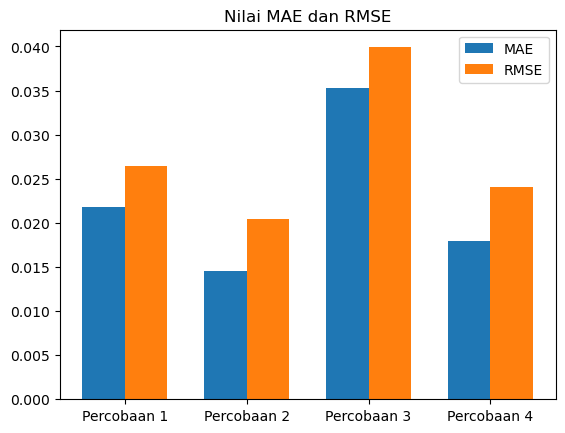

In [106]:
fig, ax = plt.subplots()
ax.bar(x - width/2, hasil_4["MAE"], width, label='MAE')
ax.bar(x + width/2, hasil_4["RMSE"], width, label='RMSE')
 
#ax.set_xlabel('Year')
ax.set_title('Nilai MAE dan RMSE')
ax.set_xticks(x, hasil_4["Percobaan"])
ax.legend()
 
plt.show()

## 7. Visualisasi Data Vanilla, Stacked, Bidirectional LSTM-RNN

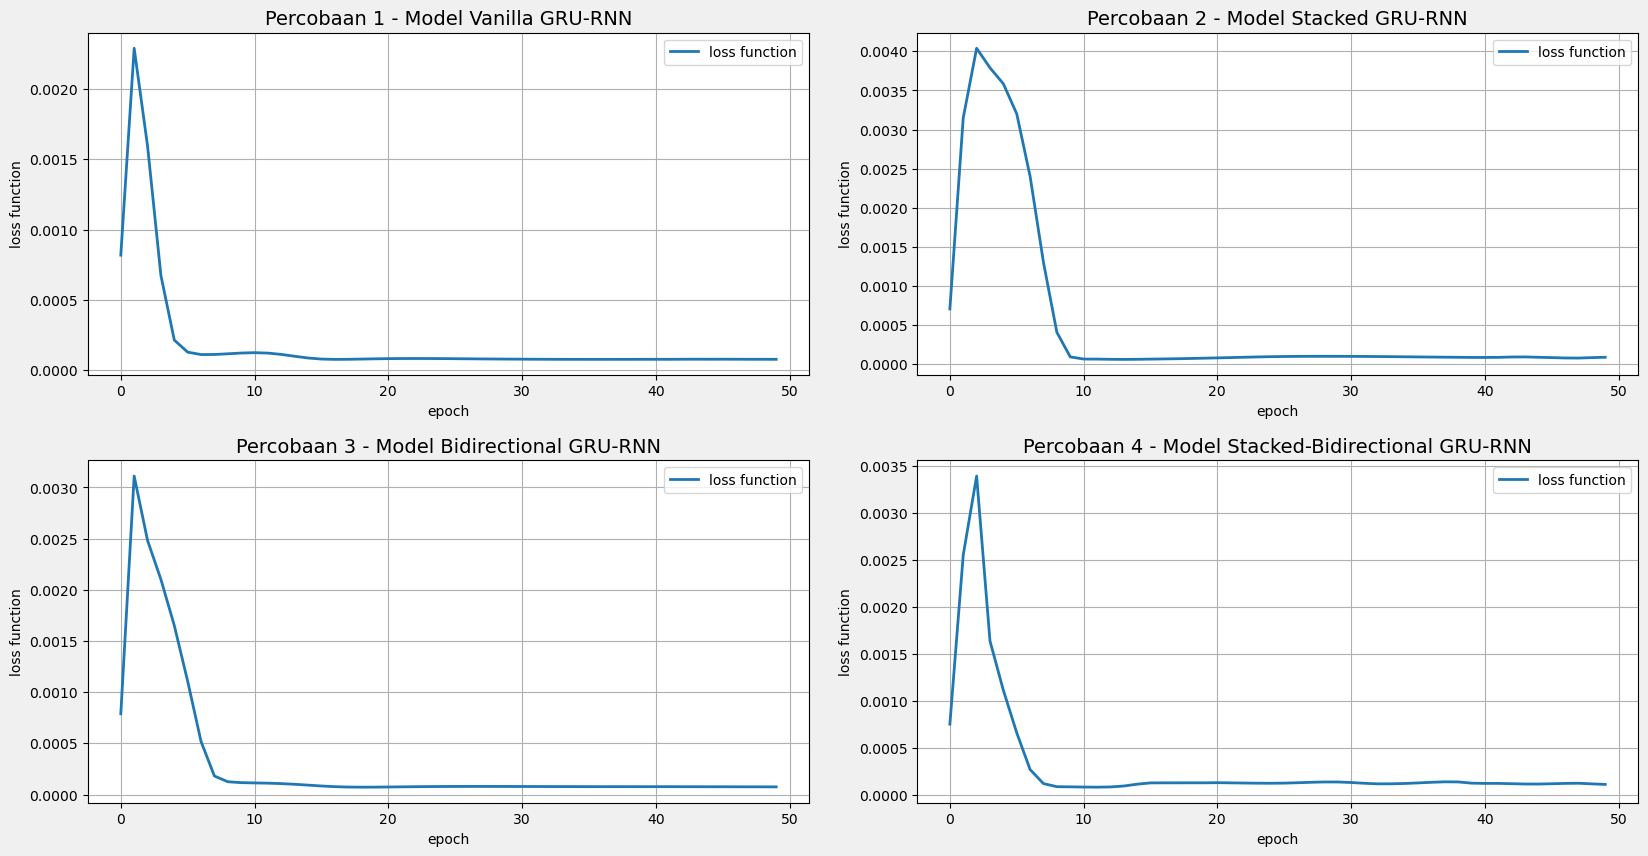

In [107]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(history_1.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax1.set_title("Percobaan 1 - Model Vanilla GRU-RNN", fontsize=14)
ax1.set_xlabel("epoch", fontsize=10)
ax1.set_ylabel("loss function", fontsize=10)
ax1.legend(loc="best")
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(history_2.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax2.set_title("Percobaan 2 - Model Stacked GRU-RNN", fontsize=14)
ax2.set_xlabel("epoch", fontsize=10)
ax2.set_ylabel("loss function", fontsize=10)
ax2.legend(loc="best")
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(history_3.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax3.set_title("Percobaan 3 - Model Bidirectional GRU-RNN", fontsize=14)
ax3.set_xlabel("epoch", fontsize=10)
ax3.set_ylabel("loss function", fontsize=10)
ax3.legend(loc="best")
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(history_4.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax4.set_title("Percobaan 4 - Model Stacked-Bidirectional GRU-RNN", fontsize=14)
ax4.set_xlabel("epoch", fontsize=10)
ax4.set_ylabel("loss function", fontsize=10)
ax4.legend(loc="best")
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

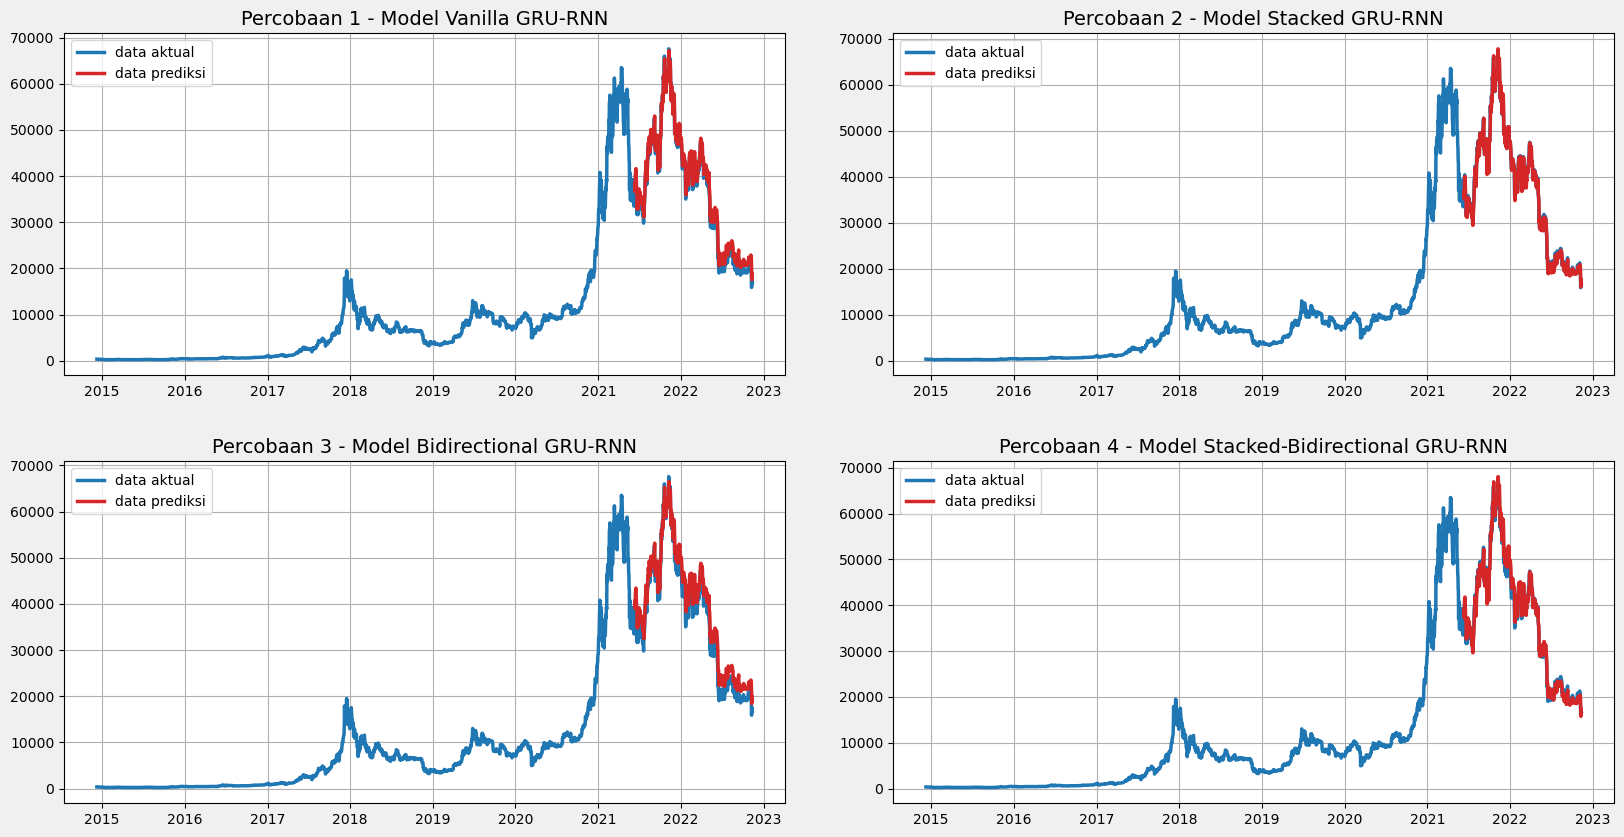

In [108]:
##### membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax1.plot(dataset.index.values, predictionsPlot_1, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax1.set_title("Percobaan 1 - Model Vanilla GRU-RNN", fontsize=14)
ax1.legend(loc="best")
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax2.plot(dataset.index.values, predictionsPlot_2, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax2.set_title("Percobaan 2 - Model Stacked GRU-RNN", fontsize=14)
ax2.legend(loc="best")
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax3.plot(dataset.index.values, predictionsPlot_3, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax3.set_title("Percobaan 3 - Model Bidirectional GRU-RNN", fontsize=14)
ax3.legend(loc="best")
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax4.plot(dataset.index.values, predictionsPlot_4, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax4.set_title("Percobaan 4 - Model Stacked-Bidirectional GRU-RNN", fontsize=14)
ax4.legend(loc="best")
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

## 8. Complexity time

In [109]:
# Set akhir waktu komputasi 
end = time.time()

In [110]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [111]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:15:59.19
